# Compliance to specification report
**Author**:  Greg Slater <br>
**Date**:  14th March 2024 <br>
**Data Scope**: article-4-direction, listed-building, conservation-area, and tree-preservation-order collections <br>
**Report Type**: Recurring daily <br>

## Purpose
This report measures resources (an instance of a dataset supplied by an LPA) on their compliance to the specification they should be following. The datasets included are those in the article-4-direction, listed-building, conservation-area, and tree-preservation-order collections which have been supplied in the latest endpoints by LPAs in the ODP and RIPA-BOPS cohorts.

Each resource is scored using three metrics:

* **Fields supplied**: The numer of fields provided which can be mapped to the specification (this may include manual re-mapping done when the endpoint was added, as well as any automatic matching done by the pipeline).
* **Fields with no errors**: The number of fields for which there are no issues with a severity level of "error" raised for any values (to see all issue types and definitions see the [`issue_type` table](https://datasette.planning.data.gov.uk/digital-land/issue_type) in Datasette).
* **Fields with correct names**: The number of fields which exactly match the specification field names.

See [this sheet](https://docs.google.com/spreadsheets/d/1DJ0wqMj-vMidzaUIqbvP0nEIY0kOcj1dd_HJk7aZuTE/edit#gid=905004357) for an illustrated example of how a dataset is scored. Note that currently scoring is done only against the full spec, not against any minimum requirement or 'mandatory' fields.

In [1]:
%pip install wget
import wget
import pandas as pd
import os
import numpy as np
import urllib


Note: you may need to restart the kernel to use updated packages.


Download helper utility files from GitHub:

In [2]:
util_file = "master_report_endpoint_utils.py"
if os.path.isfile(util_file):
    from master_report_endpoint_utils import *
else:
    url = "https://raw.githubusercontent.com/digital-land/jupyter-analysis/main/service_report/master_report/master_report_endpoint_utils.py"
    wget.download(url)
    from master_report_endpoint_utils import *

The default prioritised LPAs are used unless a specific set of LPAs is detected using an 'organisation_input.csv' file in the same directory as this notebook.

In [3]:
# Get input from .csv or use default prioritised LPAs
input_path = './organisation_input.csv'
if os.path.isfile(input_path):
    input_df = pd.read_csv(input_path)
    organisation_list = input_df['organisation'].tolist()
    print('Input file found. Using', len(organisation_list), 'organisations from input file.')
else:
    provision_df = get_provisions()
    provision_df["organisation"] = provision_df["organisation"].str.replace(":","-eng:")
    print('Input file not found. Using default list of organisations.')

# convert start_date to datetime
provision_df["start_date"] = pd.to_datetime(provision_df["start_date"])
provision_df.drop(["notes", "project", "provision_reason"], axis=1, inplace=True)

Input file not found. Using default list of organisations.


In [4]:
def get_endpoint_resource_data():
    datasette_url = "https://datasette.planning.data.gov.uk/"
  
    params = urllib.parse.urlencode({
    "sql": f"""
    select re.*, s.licence
    from reporting_latest_endpoints re
    left join (select distinct endpoint, licence from source where length(licence) < 12) s on re.endpoint = s.endpoint
    """,
    "_size": "max"
    })
    
    url = f"{datasette_url}digital-land.csv?{params}"
    df = pd.read_csv(url)
    return df

def get_fields_for_resource(resource, dataset):
    datasette_url = "https://datasette.planning.data.gov.uk/"
    params = urllib.parse.urlencode({
        "sql": f"""
        select f.field, fr.resource
        from 
            fact_resource fr
            inner join fact f on fr.fact = f.fact
        where 
            resource = '{resource}'
        group by
            f.field
        """,
        "_size": "max"
    })
    url = f"{datasette_url}{dataset}.csv?{params}"
    facts_df = pd.read_csv(url)
    # facts_list = facts_df['field'].tolist()
    return facts_df

def get_column_mappings_for_resource(resource, dataset):
    datasette_url = "https://datasette.planning.data.gov.uk/"
    params = urllib.parse.urlencode({
        "sql": f"""
        select column, field
        from 
          column_field  
        where 
            resource = '{resource}'
        """,
        "_size": "max"
    })
    url = f"{datasette_url}{dataset}.csv?{params}"
    column_field_df = pd.read_csv(url)
    return column_field_df


def get_all_issues_for_resource(resource, dataset):
    params = urllib.parse.urlencode({
        "sql": f"""
        select field, issue_type, count(*) as count_issues
        from issue
        where resource = '{resource}'
        group by field, issue_type
        """,
        "_size": "max"
    })
    url = f"{datasette_url}{dataset}.csv?{params}"
    issues_df = pd.read_csv(url)
    return issues_df


## Get endpoint data

In [5]:
# get data from datasette
endpoint_resource_df = get_endpoint_resource_data()

datasets = ['article-4-direction', 'article-4-direction-area', 'conservation-area', 'conservation-area-document',
       'listed-building-outline', 'tree', 'tree-preservation-order', 'tree-preservation-zone']

# filter to valid, active endpoints and resources
endpoint_resource_filtered_df = endpoint_resource_df[
    (endpoint_resource_df["pipeline"].isin(datasets)) &
    (endpoint_resource_df["status"] == 200) &
    (endpoint_resource_df["endpoint_end_date"].isnull()) &
    (endpoint_resource_df["resource_end_date"].isnull())
].copy()

# join to provision and bring through cohort and start date
endpoint_resource_filtered_df = endpoint_resource_filtered_df.merge(
    provision_df, 
    how = "inner", 
    on = "organisation"
)
# replace licence NaNs with blank
endpoint_resource_filtered_df["licence"].replace(np.nan, "", inplace=True)

print(len(endpoint_resource_df))
print(len(endpoint_resource_filtered_df))

print(len(endpoint_resource_filtered_df[["endpoint", "pipeline"]].drop_duplicates()))
print(len(endpoint_resource_filtered_df[["resource"]].drop_duplicates()))
print(len(endpoint_resource_filtered_df[["endpoint"]].drop_duplicates()))

163
85
85
81
81


## Get field and col mapping data

In [6]:
# table of unique resources and pipelines
resource_df = endpoint_resource_filtered_df[["pipeline", "resource"]].drop_duplicates().dropna(axis = 0)
print(len(resource_df))

issue_severity_lookup = get_issue_types_by_severity(["error"])

85


In [7]:
# generic function to try the resource datasette queries 
# will return a df with resource and dataset fields as keys, and query results as other fields
def try_results(function, resource, dataset):

    # try grabbing results
    try:
        df = function(resource, dataset)

        df["resource"] = resource
        df["dataset"] = dataset

    # if error record resource and dataset, other fields will be given NaNs in concat
    except:
        df = pd.DataFrame({"resource" : [resource],
                           "dataset" : [dataset]
        })

    return df


# get results for col mappings and fields in arrays
results_col_map = [try_results(get_column_mappings_for_resource, r["resource"], r["pipeline"]) for index, r in resource_df.iterrows()]
results_field_resource = [try_results(get_fields_for_resource, r["resource"], r["pipeline"]) for index, r in resource_df.iterrows()]
results_issues = [try_results(get_all_issues_for_resource, r["resource"], r["pipeline"]) for index, r in resource_df.iterrows()]

# concat the results, resources which errored with have NaNs in query results fields
results_col_map_df = pd.concat(results_col_map)
results_field_resource_df = pd.concat(results_field_resource)
results_issues_df = pd.concat(results_issues)

# join on severity to issues
results_issues_df = results_issues_df.merge(
    issue_severity_lookup,
    how = "inner",
    on = "issue_type"
)

# filter to just errors and get a unique list of fields with errors per dataset and resource
resource_issue_errors_df = results_issues_df[["dataset", "resource", "field"]].drop_duplicates()


# no. of resources in each query response array
print(len(results_col_map))
print(len(results_field_resource))

# no of records in each results df
print(len(results_col_map_df))
print(len(results_field_resource_df))


85
85
609
569


In [8]:
# add in match field for column mappings (lowering so that we don't exclude case mis-matches)
results_col_map_df["field_matched"] = np.where(
        (results_col_map_df["field"].isin(["geometry", "point"])) |
        (results_col_map_df["field"].str.lower() == results_col_map_df["column"].str.lower()),
        1, 
        0
)

# add in flag for fields supplied (i.e. they're in the mapping table)
results_col_map_df["field_supplied"] = 1

# add in flag for fields present
results_field_resource_df["field_loaded"] = 1

# add in flag for fields with errors
resource_issue_errors_df["field_errors"] = 1

# in issues table reference not being supplied is linked to entity. we don't count entity as a supplied 
# field (it is removed further down), so here it is re-mapped to reference field so it's included as an error
resource_issue_errors_df["field"] = resource_issue_errors_df["field"].replace("entity", "reference")

## Calculate match rates

In [9]:
dataset_field_df = pd.read_csv('https://raw.githubusercontent.com/digital-land/specification/main/specification/dataset-field.csv')

In [10]:
# rename pipeline to dataset in endpoint_resource table
endpoint_resource_filtered_df.rename(columns={"pipeline":"dataset"}, inplace=True)

# left join from endpoint resource table to all the fields that each dataset should have
resource_spec_fields_df = endpoint_resource_filtered_df[
        ["organisation", "name", "cohort", "dataset", "endpoint", "status", "latest_log_entry_date", "endpoint_entry_date", "resource", "licence"]
    ].merge(
        dataset_field_df[["dataset", "field"]],
        on = "dataset"
)

# join on field loaded flag for each resource and field
resource_fields_match = resource_spec_fields_df.merge(
    results_field_resource_df[["dataset", "resource", "field", "field_loaded"]],
    how = "left",
    on = ["dataset", "resource", "field"]
)

# join on field supplied and matched flag for each resource and field
resource_fields_map_match = resource_fields_match.merge(
    results_col_map_df[["dataset", "resource", "field", "field_supplied", "field_matched"]],
    how = "left",
    on = ["dataset", "resource", "field"]
)

# join on field errors flag for each resource and field
resource_fields_map_issues = resource_fields_map_match.merge(
    resource_issue_errors_df,
    how = "left",
    on = ["dataset", "resource", "field"]
)

# check we're not getting dupes in the left joins
print(len(resource_spec_fields_df))
print(len(resource_fields_match))
print(len(resource_fields_map_match))
print(len(resource_fields_map_issues))
# resource_fields_map_issues.head()

1374
1374
1375
1377


In [11]:
# remove fields that are auto-created in the pipeline from final table to avoid mis-counting
# ("entity", "organisation", "prefix", "point" for all but tree, and "entity", "organisation", "prefix" for tree)
resource_fields_scored = resource_fields_map_issues[
    ((resource_fields_map_issues["dataset"] != "tree") & (~resource_fields_map_issues["field"].isin(["entity", "organisation", "prefix", "point"])) |
     (resource_fields_map_issues["dataset"] == "tree") & (~resource_fields_map_issues["field"].isin(["entity", "organisation", "prefix"])))
]

# where entry-date hasn't been supplied it is auto-created - change field_loaded to NaN in these instances so we don't count it as a loaded field
entry_date_mask = ((resource_fields_scored["field"] == "entry-date") &
    (resource_fields_scored["field_supplied"].isnull()) &
    (resource_fields_scored["field_loaded"] == 1))

resource_fields_scored.loc[entry_date_mask, "field_loaded"] = np.nan
resource_fields_scored = resource_fields_scored.replace(np.nan, 0)

In [12]:
# group by and aggregate for final summaries
final_count = resource_fields_scored.groupby(
    ["organisation", "name", "cohort", "dataset", "endpoint", "licence", "resource", "status", "latest_log_entry_date", "endpoint_entry_date"]
    ).agg(
        {"field":"count",
         "field_supplied" : "sum",
         "field_matched" : "sum",
         "field_loaded" : "sum",
         "field_errors" : "sum"}
         ).reset_index(
         ).sort_values(["name"])


final_count["field_error_free"] = final_count["field_supplied"] - final_count["field_errors"]
final_count["field_error_free"] = final_count["field_error_free"].replace(-1, 0)

# add string fields for [n fields]/[total fields] style counts
final_count["field_supplied_count"] = final_count["field_supplied"].astype(int).map(str) + "/" + final_count["field"].map(str)
final_count["field_error_free_count"] = final_count["field_error_free"].astype(int).map(str) + "/" + final_count["field"].map(str)
final_count["field_matched_count"] = final_count["field_matched"].astype(int).map(str) + "/" + final_count["field"].map(str)

# create % columns
final_count["field_supplied_pct"] = final_count["field_supplied"] / final_count["field"]
final_count["field_error_free_pct"] = final_count["field_error_free"] / final_count["field"]  
final_count["field_matched_pct"] = final_count["field_matched"] / final_count["field"] 

final_count.reset_index(drop=True, inplace=True)
csv_out_cols = ['organisation', 'name', 'cohort', 'dataset', 'endpoint', 'licence', 'resource', 'status', 'latest_log_entry_date', 'endpoint_entry_date', 
                'field', 'field_supplied', 'field_matched', 'field_errors', 'field_error_free', 'field_supplied_pct', 'field_error_free_pct', 'field_matched_pct']
final_count[csv_out_cols].to_csv("report_conformance_organisation-dataset.csv")
# final_count.head()

## Report output

In [13]:
final_count_out = final_count[
    ["organisation", "name", "cohort", "dataset", "licence", "field_supplied_count", "field_supplied_pct", 
     "field_matched_count", "field_matched_pct"]
].copy()

final_count_out.sort_values(["name", "dataset"], inplace=True)

slice_ = ["field_supplied_pct", "field_matched_pct"]

final_count_out.style \
    .relabel_index(["Organisation", "Organisation Name", "Cohort", "Dataset", "Licence", "Fields supplied", "Fields supplied (%)", 
                    "Field with correct names", "Field with correct names (%)"], axis=1) \
    .format("{:.0%}", subset = slice_) \
    .background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGn", subset = slice_)

,Organisation,Organisation Name,Cohort,Dataset,Licence,Fields supplied,Fields supplied (%),Field with correct names,Field with correct names (%)
0,local-authority-eng:BIR,Birmingham City Council,ODP-Track1,article-4-direction-area,,11/12,92%,5/12,42%
1,local-authority-eng:BIR,Birmingham City Council,ODP-Track1,conservation-area,,8/10,80%,4/10,40%
4,local-authority-eng:CAT,Canterbury City Council,ODP-Track1,article-4-direction-area,,0/12,0%,0/12,0%
3,local-authority-eng:CAT,Canterbury City Council,ODP-Track1,conservation-area,,4/10,40%,2/10,20%
2,local-authority-eng:CAT,Canterbury City Council,ODP-Track1,listed-building-outline,,2/16,12%,2/16,12%
9,local-authority-eng:DNC,Doncaster Metropolitan Borough Council,RIPA-BOPS,article-4-direction-area,,6/12,50%,2/12,17%
8,local-authority-eng:DNC,Doncaster Metropolitan Borough Council,RIPA-BOPS,conservation-area,,4/10,40%,2/10,20%
7,local-authority-eng:DNC,Doncaster Metropolitan Borough Council,RIPA-BOPS,listed-building-outline,ogl3,1/16,6%,1/16,6%
6,local-authority-eng:DNC,Doncaster Metropolitan Borough Council,RIPA-BOPS,tree,ogl3,5/15,33%,1/15,7%
5,local-authority-eng:DNC,Doncaster Metropolitan Borough Council,RIPA-BOPS,tree-preservation-zone,ogl3,7/13,54%,2/13,15%


## Dataset level conformance scores

In [14]:
# get list of orgs and datasets with bad endpoints (returning 0 data) to exclude from these results
bad_endpoints = final_count[final_count["field_supplied"] == 0][["organisation", "dataset"]]

print(len(resource_fields_scored))

# flag bad endpoints
resource_fields_scored_no_zeros = resource_fields_scored.merge(
    bad_endpoints,
    how = "left",
    on = ["organisation", "dataset"],
    indicator = True
)
# remove
resource_fields_scored_no_zeros = resource_fields_scored_no_zeros[resource_fields_scored_no_zeros["_merge"] == "left_only"]

print(len(resource_fields_scored_no_zeros))



1062
1050


### Dataset field summaries

In [15]:
# summarise scores for dataset and fields
dataset_field_summary = resource_fields_scored_no_zeros.groupby(["dataset", "field"]).agg(
        {"resource":"count",
         "field_supplied" : "sum",
         "field_matched" : "sum",
         "field_errors" : "sum"}
         ).reset_index()

dataset_field_summary["field_supplied_pct"] = dataset_field_summary["field_supplied"] / dataset_field_summary["resource"]
dataset_field_summary["field_matched_pct"] = dataset_field_summary["field_matched"] / dataset_field_summary["resource"]
dataset_field_summary["field_errors_pct"] = dataset_field_summary["field_errors"] / dataset_field_summary["resource"]

dataset_field_summary.rename(columns={
    "resource" : "n_orgs",
    "field_supplied":"field_supplied_count",
    "field_matched":"field_matched_count",
    "field_errors":"field_errors_count"
}, inplace = True)

dataset_field_summary.to_csv("report_conformance_dataset-field.csv", index = False)
dataset_field_summary_rp = dataset_field_summary[["dataset", "field",  "field_supplied_pct", "field_matched_pct"]].copy()

In [16]:
def make_pretty(styler):
    styler.relabel_index(["Dataset", "Field name", "Field supplied (%)", "Field name matched (%)"], axis=1)
    styler.format("{:.0%}", subset = ["field_supplied_pct", "field_matched_pct"])
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGn", subset = ["field_supplied_pct", "field_matched_pct"])
    return styler

In [17]:
dataset_name = "article-4-direction-area"

n_orgs = len(resource_fields_scored_no_zeros[resource_fields_scored_no_zeros["dataset"] == dataset_name][["organisation"]].drop_duplicates())
print(f"Number of LPAs with active endpoints for this dataset: {n_orgs}")
dataset_field_summary_rp[dataset_field_summary["dataset"] == dataset_name].style.pipe(make_pretty)

Number of LPAs with active endpoints for this dataset: 15


,Dataset,Field name,Field supplied (%),Field name matched (%)
9,article-4-direction-area,address-text,53%,13%
10,article-4-direction-area,article-4-direction,67%,20%
11,article-4-direction-area,description,20%,13%
12,article-4-direction-area,end-date,73%,20%
13,article-4-direction-area,entry-date,80%,20%
14,article-4-direction-area,geometry,100%,100%
15,article-4-direction-area,name,93%,93%
16,article-4-direction-area,notes,60%,60%
17,article-4-direction-area,permitted-development-rights,53%,13%
18,article-4-direction-area,reference,93%,80%


### Dataset summaries

In [18]:
# summarise scores for datasets
dataset_summary = resource_fields_scored_no_zeros.groupby(["dataset"]).agg(
        {"field":"nunique",
         "organisation":"nunique",
         "field_supplied" : "sum",
         "field_matched" : "sum",
         "field_errors" : "sum"}
         ).reset_index()

dataset_summary["field_supplied_avg"] = dataset_summary["field_supplied"] / dataset_summary["organisation"]
dataset_summary["field_matched_avg"] = dataset_summary["field_matched"] / dataset_summary["organisation"]
dataset_summary["field_errors_avg"] = dataset_summary["field_errors"] / dataset_summary["organisation"]

dataset_summary.rename(columns = {
    "field":"n_fields",
    "organisation":"n_orgs",
    "field_supplied":"field_supplied_total",
    "field_matched":"field_matched_total",
    "field_errors":"field_errors_total"
    },
    inplace = True
)

dataset_summary.to_csv("report_conformance_dataset.csv", index = False)

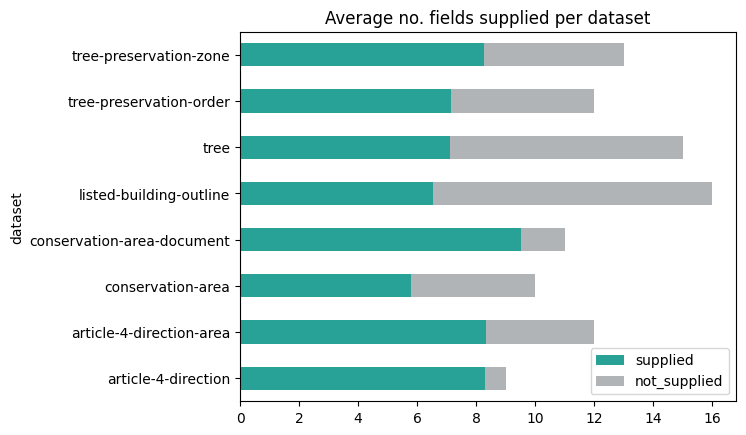

In [19]:
dataset_summary_plt = pd.DataFrame({'supplied': dataset_summary["field_supplied_avg"].values,
              'not_supplied': dataset_summary["n_fields"].values - dataset_summary["field_supplied_avg"].values}, 
              index=dataset_summary["dataset"])

ax = dataset_summary_plt.plot.barh(
                  stacked=True, 
                  color = {"supplied": "#28a197", "not_supplied": "#b1b4b6"},
                  title = "Average no. fields supplied per dataset")